In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
%matplotlib inline
url="https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv"
data = pd.read_csv(url)
print(data.info())
print("\n Embarked options: ", data["Embarked"].value_counts())

data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None

 Embarked options:  S    644
C    168
Q     77
Name: Embarked, dtype: int64


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
#Apply less memory-consuming data types to the data 

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# setting up new data types
dtypes_col       = data.columns
dtypes_type_old  = data.dtypes
dtypes_type      = ['int16', 'bool','category','object','category','float32','int8','int8','object','float32','object','category']
optimized_dtypes = dict(zip(dtypes_col, dtypes_type))

In [7]:
#read data once again with optimized columns
data_optimized = pd.read_csv(url,dtype=optimized_dtypes)
test_optimized = pd.read_csv(url,dtype=optimized_dtypes)

#splitting data to train and validation
train, valid = train_test_split(data_optimized, test_size=0.2)


In [8]:
combined = {"train":train,
            "valid":valid,
            "test":test_optimized}

print(data_optimized.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int16
Survived       891 non-null bool
Pclass         891 non-null category
Name           891 non-null object
Sex            891 non-null category
Age            714 non-null float32
SibSp          891 non-null int8
Parch          891 non-null int8
Ticket         891 non-null object
Fare           891 non-null float32
Cabin          204 non-null object
Embarked       889 non-null category
dtypes: bool(1), category(3), float32(2), int16(1), int8(2), object(3)
memory usage: 35.2+ KB
None


In [9]:
#Do we have any missing data?
data_optimized.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
#"Cabin" column will not be interesting for us, because there is a lot of missing data.
#"Age" column may be important for the model, and but some of decision tree models 
#have a mechanism for estimating missing value based on correlation with other values if possible.

In [11]:
combined_cleaned = {}
for i,data in combined.items():
    combined_cleaned[i] = data.drop('Cabin', 1).copy()

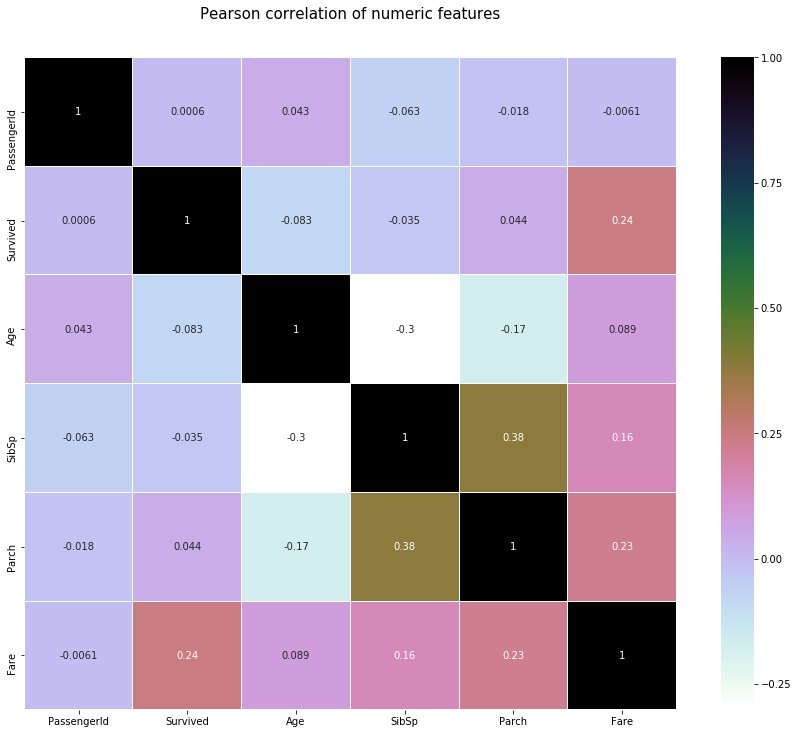

In [12]:
#numerical features

train_numeric = combined_cleaned["train"].select_dtypes(include=['float32','int16','int8','bool'])

colormap = plt.cm.cubehelix_r
plt.figure(figsize=(16,12))

plt.title('Pearson correlation of numeric features', y=1.05, size=15)
sns.heatmap(train_numeric.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [13]:
#Two interesting correlations are:

#positive (0.41) for "SibSp" and "Parch"
#negative (-0.31) for "SibSp" and "Age"

In [14]:
# category features# category features

#we do not count NaN categories
def survived_percent(categories,column):
    survived_list = []
    for c in categories.dropna():
        count = combined_cleaned["train"][combined_cleaned["train"][column] == c][column].count()
        survived = combined_cleaned["train"][combined_cleaned["train"][column] == c]["Survived"].sum()/count
        survived_list.append(survived)
    return survived_list    

In [15]:
category_features_list = ["Sex", "Embarked","Pclass"]
category_features = {}

for x in category_features_list:
    unique_values = combined_cleaned["train"][x].unique().dropna()
    survived = survived_percent(unique_values,x)
    category_features[x] = [unique_values, survived]

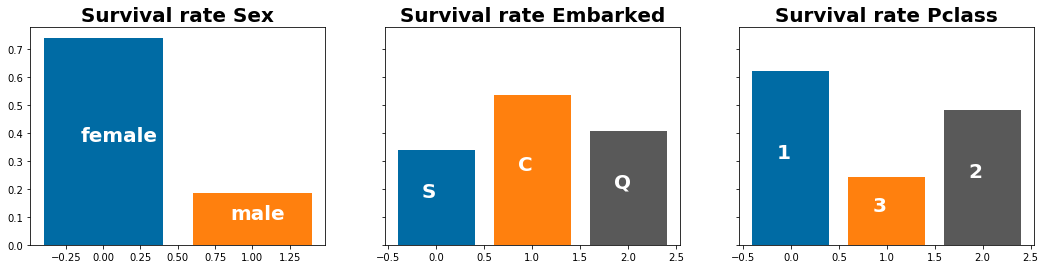

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
cb_dark_blue = (0/255,107/255,164/255)
cb_orange = (255/255, 128/255, 14/255)
cb_grey = (89/255, 89/255, 89/255)
color=[cb_dark_blue,cb_orange,cb_grey]
font_dict = {'fontsize':20, 
             'fontweight':'bold',
             'color':"white"}

for i,cat in enumerate(category_features.keys()):
    number_categories = len(category_features[cat][0])
    axs[i].bar(range(number_categories), category_features[cat][1], color=color[:number_categories])
    axs[i].set_title("Survival rate " + cat ,fontsize=20, fontweight='bold' )
    for j,indx in enumerate(category_features[cat][1]):
        label_text = category_features[cat][0][j]
        x = j
        y = indx
        axs[i].annotate(label_text, xy = (x-0.15 ,y/2), **font_dict )


In [17]:
#Gender is a key factor insurvival rate.

#for i in range(3):
 #   axs[i].tick_params(
  #      axis='x',          # changes apply to the x-axis
   #     which='both',      # both major and minor ticks are affected
    #    bottom='off',      # ticks along the bottom edge are off
     #   top='off',         # ticks along the top edge are off
      #  labelbottom='off') # labels along the bottom edge are off
    #axs[i].patch.set_visible(False)

In [18]:
#3. Filling missing data
#For "Embarked" colum we will use most popular category which is "S", because there are 
#only 2 records missing.
#For "Age" column as a first attempt we will use age distribution  FAge  known 
#from the rest of the data and generate random number from it.

In [19]:
# filling NaN in "Embarked" and "Fare"

for i,data in combined_cleaned.items():
    data["Embarked"].fillna(value="S",inplace=True) # S is most popular value 
    mean_Fare = data["Fare"].mean()
    data["Fare"].fillna(value=mean_Fare,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


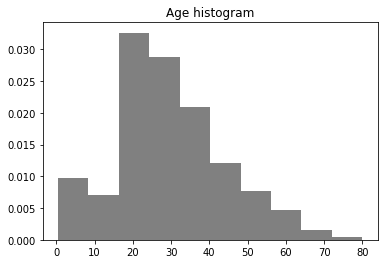

In [20]:
# filling NaN in "Age" 
fig, ax = plt.subplots( figsize=(6,4))
x = combined_cleaned["train"]["Age"].dropna()
hist, bins = np.histogram( x,bins=15)

#plot of histogram
ax.hist(x, normed=True, color='grey')
ax.set_title('Age histogram')
plt.show()

In [21]:
from random import choices

bin_centers = 0.5*(bins[:len(bins)-1]+bins[1:])
probabilities = hist/hist.sum()

#dictionary with random numbers from existing age distribution
for i,data in combined_cleaned.items():
    data["Age_rand"] = data["Age"].apply(lambda v: np.random.choice(bin_centers, p=probabilities))
    Age_null_list   = data[data["Age"].isnull()].index
    
    data.loc[Age_null_list,"Age"] = data.loc[Age_null_list,"Age_rand"]

In [22]:
#4. Modelling
#a) C&RT decision tree

In [23]:
from sklearn import preprocessing,tree
from sklearn.model_selection import GridSearchCV

tree_data = {}
tree_data_category = {}

for i,data in combined_cleaned.items():
    tree_data[i] = data.select_dtypes(include=['float32','int16','int8']).copy()
    tree_data_category[i] = data.select_dtypes(include=['category'])

    #categorical variables handling
    for column in tree_data_category[i].columns:
        le = preprocessing.LabelEncoder()
        le.fit(data[column])
        tree_data[i][column+"_encoded"] = le.transform(data[column])

In [24]:
#finding best fit with gridsearch
param_grid = {'min_samples_leaf':np.arange(20,50,5),
              'min_samples_split':np.arange(20,50,5),
              'max_depth':np.arange(3,6),
              'min_weight_fraction_leaf':np.arange(0,0.4,0.1),
              'criterion':['gini','entropy']}
clf = tree.DecisionTreeClassifier()
tree_search = GridSearchCV(clf, param_grid, scoring='average_precision')

X =  tree_data["train"].drop("PassengerId",axis=1)
Y = combined_cleaned["train"]["Survived"]
tree_search.fit(X,Y)

print("Tree best parameters :",tree_search.best_params_)
print("Tree best estimator :",tree_search.best_estimator_ )
print("Tree best score :",tree_search.best_score_ )


Tree best parameters : {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 25, 'min_samples_split': 25, 'min_weight_fraction_leaf': 0.0}
Tree best estimator : DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=25, min_samples_split=25,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Tree best score : 0.7930196981778758


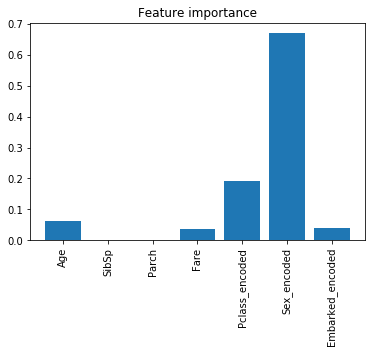

In [25]:
tree_best_parameters = tree_search.best_params_
tree_optimized = tree.DecisionTreeClassifier(**tree_best_parameters)
tree_optimized.fit(X,Y)

train_columns = list(tree_data["train"].columns)
train_columns.remove("PassengerId")
fig, ax = plt.subplots( figsize=(6,4))
ax.bar(range(len(X.columns)),tree_optimized.feature_importances_ )
plt.xticks(range(len(X.columns)),X.columns,rotation=90)
ax.set_title("Feature importance")
plt.show()

In [26]:
import graphviz

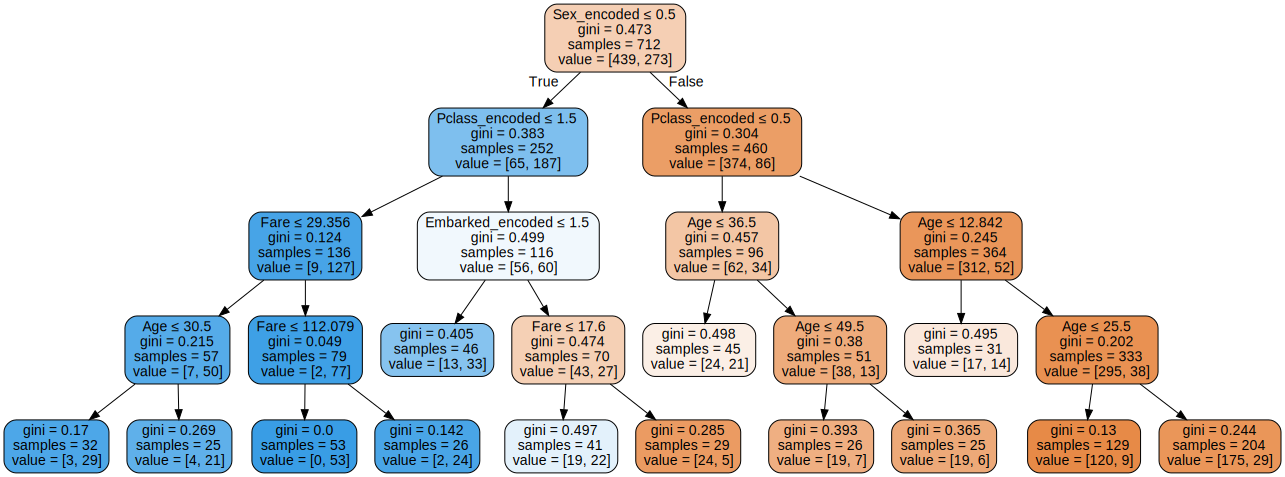

In [27]:
import graphviz
dot_data = tree.export_graphviz(tree_optimized, 
                                out_file=None,
                                filled=True, 
                                rounded=True,  
                                special_characters=True,
                               feature_names = train_columns) 
graph = graphviz.Source(dot_data)
graph

In [28]:
#Prediction on the test set

In [29]:
test_without_PId = tree_data["test"].drop("PassengerId",axis=1)
prediction_values = tree_optimized.predict(test_without_PId).astype(int)
prediction = pd.DataFrame({"PassengerId":tree_data["test"]["PassengerId"],
                           "Survived":prediction_values})

prediction.head()
prediction.to_csv("Titanic_tree_prediction.csv",index=False)


In [30]:
#Performance evaluation

In [31]:
from sklearn.metrics import confusion_matrix

evaluation = {}
cm = {}


valid_without_PId = tree_data["valid"].drop("PassengerId",axis=1)
evaluation["tree"] = tree_optimized.predict(valid_without_PId).astype(int)
survival_from_data = combined_cleaned["valid"]["Survived"].astype(int)

print(survival_from_data.value_counts())

cm["tree"] = confusion_matrix(survival_from_data, evaluation["tree"])
cm["tree"] = cm["tree"].astype('float') / cm["tree"].sum(axis=1)[:, np.newaxis]

cm["tree"]

0    110
1     69
Name: Survived, dtype: int64


array([[0.90909091, 0.09090909],
       [0.33333333, 0.66666667]])

In [32]:
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
#Into the woods - random forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

clf_forest = RandomForestClassifier(n_estimators=10,min_samples_leaf=20, max_depth=4,min_weight_fraction_leaf=0.1)
clf_forest.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.1, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
prediction_values_forest = clf_forest.predict(test_without_PId).astype(int)
prediction_forest = pd.DataFrame({"PassengerId":tree_data["test"]["PassengerId"],
                           "Survived":prediction_values_forest})

#prediction_forest.to_csv("Titanic_tree_prediction_forest.csv",index=False)

In [42]:
#Random forest with parameters optimization

In [44]:
param_grid = {'n_estimators':np.arange(3,11,2),
              'max_depth':np.arange(3,6),
              'min_weight_fraction_leaf':np.arange(0,0.4,0.1),
              'criterion':['gini','entropy']}
clf = RandomForestClassifier()
forest_search = GridSearchCV(clf, param_grid, scoring='precision')

forest_search.fit(X,Y)

print("Forest best parameters :",forest_search.best_params_)
print("Forest best estimator :",forest_search.best_estimator_ )
print("Forest best score :",forest_search.best_score_ )

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: U

Forest best parameters : {'criterion': 'entropy', 'max_depth': 5, 'min_weight_fraction_leaf': 0.30000000000000004, 'n_estimators': 7}
Forest best estimator : RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.30000000000000004, n_estimators=7,
            n_jobs=1, oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Forest best score : 0.9435318017656501


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [45]:
clf_forest = RandomForestClassifier(**forest_search.best_params_)
clf_forest.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.30000000000000004, n_estimators=7,
            n_jobs=1, oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
prediction_values_forest = clf_forest.predict(test_without_PId).astype(int)
prediction_forest = pd.DataFrame({"PassengerId":tree_data["test"]["PassengerId"],
                           "Survived":prediction_values_forest})

prediction_forest.to_csv("Titanic_tree_prediction_forest.csv",index=False)

In [47]:
#Performance evaluation

[[1. 0.]
 [1. 0.]]


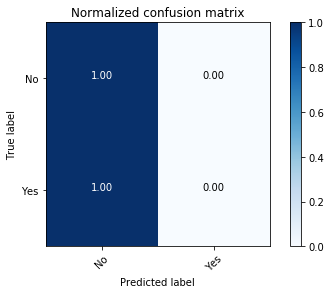

In [48]:
evaluation["forest"] = clf_forest.predict(valid_without_PId).astype(int)

cm["forest"] = confusion_matrix(survival_from_data, evaluation["forest"])
cm["forest"] = cm["forest"].astype('float') / cm["forest"].sum(axis=1)[:, np.newaxis]

cm["forest"]

plot_confusion_matrix(cm["forest"], classes=["No","Yes"], 
                      title='Normalized confusion matrix')

In [49]:
#Naive Bayes

In [50]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X, Y)

GaussianNB(priors=None)

In [51]:
prediction_values_NaiveBayes = gnb.predict(test_without_PId).astype(int)
prediction_NaiveBayes = pd.DataFrame({"PassengerId":tree_data["test"]["PassengerId"],
                           "Survived":prediction_values_NaiveBayes})

#prediction_NaiveBayes.to_csv("Titanic_tree_prediction_NaiveBayes.csv",index=False)

In [52]:
#Performance evaluation

[[0.87272727 0.12727273]
 [0.27536232 0.72463768]]


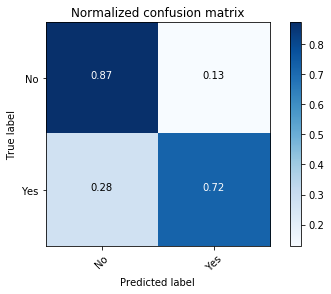

In [53]:
evaluation["NB"] = gnb.predict(valid_without_PId).astype(int)

cm["NB"] = confusion_matrix(survival_from_data, evaluation["NB"])
cm["NB"] = cm["NB"].astype('float') / cm["NB"].sum(axis=1)[:, np.newaxis]

cm["NB"]

plot_confusion_matrix(cm["NB"], classes=["No","Yes"], 
                      title='Normalized confusion matrix')

In [54]:
#Support Vector Machines

In [55]:
from sklearn import svm
clf_svm = svm.SVC()
clf_svm.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [56]:
prediction_values_svm = clf_svm.predict(test_without_PId).astype(int)
prediction_svm = pd.DataFrame({"PassengerId":tree_data["test"]["PassengerId"],
                           "Survived":prediction_values_svm})

#prediction_svm.to_csv("Titanic_tree_prediction_svm.csv",index=False)